<a href="https://colab.research.google.com/github/AramisRamirezITT/Genetic_Algorithm-Travelers_Problem/blob/main/Algoritmo_Viajero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmo genetico 

# Importacion de librerias a utilizar 

In [1]:
__author__ = ["J.L Aramis Ramirez Diaz"]
__credits__ = ["J.L Aramis Ramirez Diaz", "Dr. Marco Antonio Paz Ramos"]
__license__ = "MIT"
__version__ = "1.0.0"
__maintainer__ = ["J.L Aramis Ramirez Diaz"]
__email__ = "jdiaz@uag.edu.mx"
__status__ = "Development"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from numba import jit, cuda

! nvidia-smi

Tue Mar 14 00:36:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Declaracion del Diccionario de Ciudades (Tabla Hash)


In [2]:
dict_city = {     '1':[1,3], '2': [2,5], '3':[2,7], '4':[4, 2], '5':[4,4], 
                  '6':[4,7], '7':[4,8], '8':[5,3], '9':[6, 1], '10':[6,6], 
                  '11':[7,8],'12':[8,2], '13':[8,7], '14':[9,3], '15':[10, 7], 
                  '16':[11,1],'17':[11,4], '18':[11,6], '19':[12, 7], '20':[13, 5] }

## Funcion para calcular la distancia euclidiana de dos puntos

In [3]:
@jit(target_backend='cuda') 
def distances(element1, element2):
    element1 = str(int(element1))
    element2 = str(int(element2))
    return np.linalg.norm( np.array(dict_city[element1]) - np.array(dict_city[element2]))

## Declaracion de la matriz de numeros aleatorios entre 1 y 20 de MxN donde M = 100, N = 20

In [4]:
# #MxN = Fila x Columna
matrix = np.empty((100, 20), dtype=int) # Matriz de 
for i in range(100):
    matrix[i] = np.random.choice(range(1, 21), size=20, replace=False)

matrix_children = np.zeros((100, 20)) # Matriz de 
matrix_gen = np.zeros((100, 20)) # Matriz de 


print(matrix.shape)


(100, 20)


## Modo de Reproduccion #1

In [5]:
test_list = matrix[0, :].copy()
print(test_list)

[ 3 15 10  1  6  7  8  5 16 11  2  9 20 19 14 17 13 12 18  4]


In [6]:
@jit(target_backend='cuda') 
def Mode_0(test_list):
    inicio_a = np.random.randint(0, 10)
    longitud_b = np.random.randint(0, 10)
    longitud = np.random.randint(0, 10) 
    
    # print(np.arange(0, 20))
    # print(longitud, inicio_a, longitud_b)
    
    
    inicio_aa = inicio_a - longitud
    fin_aa =  inicio_a
    if inicio_aa < 0:
        inicio_aa = 0
        fin_aa = longitud 
    inicio_bb =  fin_aa + longitud_b 
    fin_bb = inicio_bb + longitud
    if fin_bb > matrix.shape[1]:   
        inicio_bb =  matrix.shape[1] - longitud
        fin_bb = matrix.shape[1]
    
    # print('Vector_A', inicio_aa, fin_aa - 1)
    # print('Vector_B', inicio_bb , fin_bb - 1)

    # print('a', test_list[inicio_aa: fin_aa])
    # print('b', test_list[inicio_bb: fin_bb])
    
    aux = test_list[inicio_aa: fin_aa].copy()
    
    test_list[inicio_aa: fin_aa] = test_list[inicio_bb: fin_bb]
    test_list[inicio_bb: fin_bb] = aux

   
    return test_list

# print(test_list)
# test_mylist = Mode_0(test_list)
# print(test_mylist)
# print(np.arange(0, 20))


## Modo de reprouccion #2

In [7]:
@jit(target_backend='cuda') 
def Mode_1(test_list):
    longitud_2 = np.random.randint(0, matrix.shape[1] - 1)
    diferencia = matrix.shape[1] - longitud_2 - 1 
    inicio =  np.random.randint(0, diferencia)
    fin = inicio + longitud_2

    # print(longitud_2 , inicio, fin)
    test_list[inicio: fin] = np.flip(test_list[inicio: fin])
    return test_list
    
# print(test_list)
# test_mylist = Mode_1(test_list)
# print(test_mylist)
# inicio = np.random.randint(0, )

## Etiquetas de los Cromosomas 

In [8]:
@jit(target_backend='cuda') 
def Amp_function(matrix, renglones):
    vector_distance = np.zeros((renglones, 1))
    distance_pair = 0
    for fila in range(0, matrix.shape[0]): #filas
        for columna in range(0, matrix.shape[1] - 1): #columnas   
            distance_pair += distances(matrix[fila][columna],   matrix[fila][columna + 1]) 
        
        vector_distance[fila] = distance_pair
        distance_pair = 0
    
    matrix_plus_result = np.hstack((matrix, vector_distance)) # pegar el vector y la matriz
    
    return matrix_plus_result 

# print(matrix_plus_result[np.random.randint(0, 100), 20]) 

## Torneo

In [9]:
# 2 modos 
#segmento de 2, 10 
#Segmento de longitud aleatoria darle reverse (2, 9)
@jit(target_backend='cuda') 
def tournament(matrix, matrix_children, matrix_plus_result, renglones):
    list_tournament = [[], []]
    for fila in range(0, matrix.shape[0]): #filas
    # for fila in range(0, 2): #filas
        for i in range(0, 5):
            random_num = np.random.randint(0, renglones)
            list_tournament[0].append(matrix_plus_result[random_num, 20])
            list_tournament[1].append(random_num) 
        
        winner = min(list_tournament[0])
        index  = list_tournament[1][list_tournament[0].index(winner)]
    
        # print(winner)
        # print(matrix_plus_result[index, :])
        # print(matrix[index, :])
        # print(matrix[fila, :])
        # print('-'*100)
          
        dado = np.random.randint(0, 2)
        
        if dado == 0:
            matrix_children[fila] = Mode_0(matrix[index, :].copy())
        else:
            matrix_children[fila] = Mode_1(matrix[index, :].copy())                
        
        list_tournament = [[], []]

    return matrix_children


# print(Amp_function(tournament(matrix, matrix_children,  Amp_function(matrix))))


## Graficacion

In [10]:
@jit(target_backend='cuda') 
def graficar(dict_city, test_list, iteracion, vec_min,  x_d ,lista_de_test ,dist_min):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    x = [dict_city[str(int(i))][0] for i in test_list]
    y = [dict_city[str(int(i))][1] for i in test_list]
    
    if iteracion == 0:
        iteracion = 1
    

    axs[0].grid( linestyle='dotted', linewidth=1)
    axs[0].scatter(x, y, color='r')
    axs[0].plot(x, y)
    
    axs[0].set_title(f'Mejor ruta: {np.array(vec_min, dtype=int)}' , fontsize=10)
    
    for i in test_list:
        axs[0].annotate(str(int(i)), (dict_city[str(int(i))][0], dict_city[str(int(i))][1]))
    
    axs[1].grid( linestyle='dotted', linewidth=1)
    axs[1].plot(np.array(x_d), np.array(lista_de_test))
    axs[1].set_title(f'Distancia actual: {dist_min}' , fontsize=10)
    
    fig.suptitle(f'Algortimo Genetico - Problema del Viajero(TSP) - Generacion:{iteracion + 1}',  fontsize=14, y=0.98)
    fig.tight_layout()
    
    display(fig)
    clear_output(wait = True)
    plt.pause(0.01)
    


## Funcion plot mejor generacion

In [11]:
@jit(target_backend='cuda') 
def plot_bestGen(matrix_gen, best_gen):
  fig, axs = plt.subplots(1, 1, figsize=(10, 10))

  x = [dict_city[str(int(i))][0] for i in np.array(matrix_gen[best_gen - 1,0:20].copy() , dtype=int)]
  y = [dict_city[str(int(i))][1] for i in np.array(matrix_gen[best_gen - 1,0:20].copy() , dtype=int)]


  axs.grid( linestyle='dotted', linewidth=1)
  axs.scatter(x, y, color='r')
  axs.plot(x, y)


  for i in test_list:
    axs.annotate(str(int(i)), (dict_city[str(int(i))][0], dict_city[str(int(i))][1]))

  fig.suptitle(f'Rtua de la mejor Generacion:{best_gen}',  fontsize=14, y=0.98)
  fig.tight_layout()

## Funcion Resultado

In [17]:
@jit(target_backend='cuda') 
def run(iteraciones, renglones):
  dist_min_x_gen = []
  x_d = []

  
  matrix = np.zeros((renglones, 20), dtype=int) # Matriz de 
  
  for i in range(renglones):
      matrix[i] = np.random.choice(range(1, 21), size=20, replace=False).astype('int')

  matrix_children = np.zeros((renglones, 20)) # Matriz de 
  matrix_gen = np.zeros((renglones, 20)) # Matriz de 
  # vector_winners = np.zeros((100, 2))

  for i in range(0, iteraciones):   
      matrix_labeled = Amp_function(matrix, renglones) # Saca las distancias de las generaciones y agrega un vector columna a las matrix   
      matrix_generation = tournament(matrix, matrix_children, matrix_labeled, renglones) # Realiza el toreno
      matrix = matrix_generation # Matriz de hijos sustituye a la de padres 
      
      dist_min = min(matrix_labeled[:,20])
      x_d.append(i)    
      dist_min_x_gen.append(dist_min)
      index_min = np.where(matrix_labeled[:,20] == dist_min)
      vec_min = matrix_labeled[index_min[0][0],:20 ].copy()      
      matrix_gen[i, :20] = vec_min
    
      graficar(dict_city, vec_min, i, vec_min, x_d , dist_min_x_gen, dist_min)


  best_gen = dist_min_x_gen.index(min(dist_min_x_gen)) + 1
  print('Distancia minima registrada:', min(dist_min_x_gen))
  print('Mejor generacion:', best_gen)
  print(f'Mejor ruta (Generacion - {best_gen}):', np.array(matrix_gen[best_gen - 1,:20].copy() , dtype=int))
  print(f'Maxima distancia registrada (Generacion - {dist_min_x_gen.index(max(dist_min_x_gen)) + 1}):', max(dist_min_x_gen))
  plot_bestGen(matrix_gen, best_gen)

# Resultado


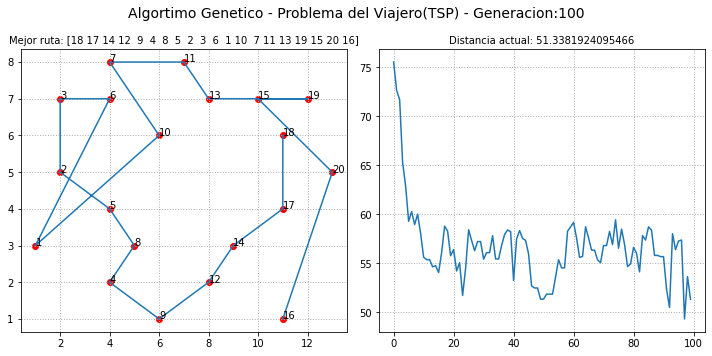

Distancia minima registrada: 49.3381924095466
Mejor generacion: 98
Mejor ruta (Generacion - 98): [18 17 14 12  9  4  8  5 10  1  6  3  2  7 11 13 15 19 20 16]
Maxima distancia registrada (Generacion - 1): 75.53547926602211


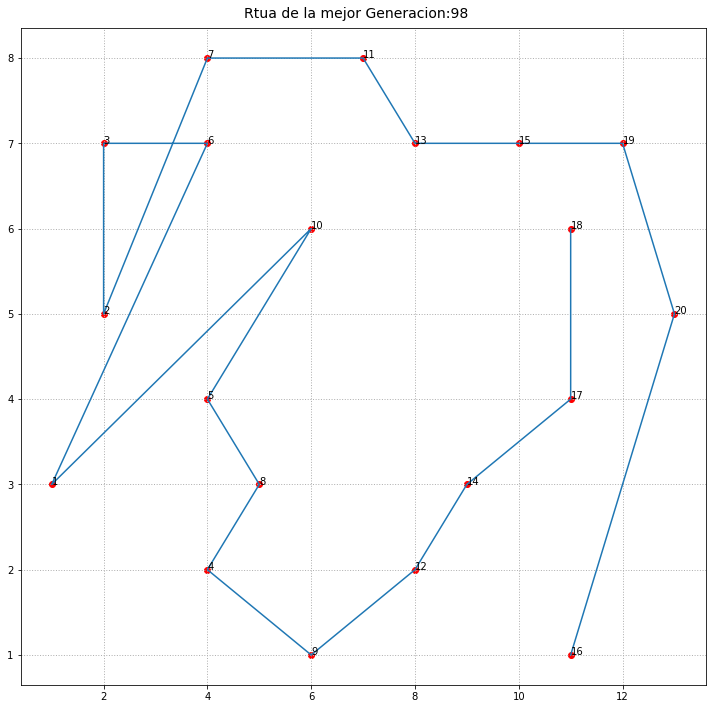

In [18]:
run(100, 500)